# Environmental Health Project Data Analysis

In [84]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [85]:
# load python libraries
import sys
import pandas as pd
import numpy as np
import scipy
import statsmodels
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind, t
from scipy.stats import ttest_rel, t
from scipy.stats import sem
from scipy.stats import spearmanr
from statsmodels.stats.contingency_tables import mcnemar
from statsmodels.stats.proportion import proportion_confint
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import AnovaRM

# print library versions
print()
print('You might want to include the version of Python, as well as relevant libraries in your methods section for the publication.')
print()
print('Python version: {}'.format(sys.version))
print('Pandas version: {}'.format(pd.__version__))
print('Scipy version: {}'.format(scipy.__version__))
print('statsmodels version: {}'.format(statsmodels.__version__))



You might want to include the version of Python, as well as relevant libraries in your methods section for the publication.

Python version: 3.9.6 (default, Feb  3 2024, 15:58:27) 
[Clang 15.0.0 (clang-1500.3.9.4)]
Pandas version: 2.2.2
Scipy version: 1.13.1
statsmodels version: 0.14.2


In [86]:
# clean data and perform analysis of internal consistency and composite scores to create new variables
# load data
pre1 = pd.read_csv('raw_data/EH Pre-Survey_April 24, 2024_14.33.csv')
pre2 = pd.read_csv('raw_data/2024 EH Pre-Survey_April 24, 2024_14.35.csv')
post1 = pd.read_csv('raw_data/EH Post-Survey_April 24, 2024_14.34.csv')
post2 = pd.read_csv('raw_data/EH 2024 Post-Survey_April 24, 2024_14.36.csv')

# Collect questions dictionary before cleaning
pre1 = pre1.filter(regex='^Q')
questions = pre1.iloc[0].to_dict()

# remove first two rows from all 4 dataframes
pre1 = pre1[2:]
pre2 = pre2[2:]
post1 = post1[2:]
post2 = post2[2:]

# concatenate pre and post dataframes
pre = pd.concat([pre1, pre2])
post = pd.concat([post1, post2])

# numerical
columns_to_convert = ['Q2_1', 'Q3_1', 'Q3_2', 'Q3_3', 'Q3_4', 'Q3_5', 'Q3_6', 'Q3_7', 'Q8_1', 'Q8_2', 'Q8_3', 'Q8_4', 'Q8_5', 'Q8_6', 'Q9_1']

# Define a function to clean dataframes
def clean_dataframe(df):
    df = df.filter(regex='^Q')  # Keep columns starting with "Q"
    df = df.drop(columns=['Q10'])  # Drop Q10 column
    df = df.dropna(how='all')  # if a row is completely empty, drop it
    for column in columns_to_convert:
        df[column] = pd.to_numeric(df[column], errors='coerce')  # Convert columns to numeric data type
    return df

# Clean each dataframe without enumeration
pre_unmatched = clean_dataframe(pre)
post_unmatched = clean_dataframe(post)
pre1 = clean_dataframe(pre1)
pre2 = clean_dataframe(pre2)

# create pre_matched and post_matched dataframes. Start by removing when 'Q1' is missing
pre_matched = pre.dropna(subset=['Q1'])
post_matched = post.dropna(subset=['Q1'])

# only keep rows where there is a matching NetID
# make Q1 to upper case
pre_matched['Q1'] = pre_matched['Q1'].str.upper()
post_matched['Q1'] = post_matched['Q1'].str.upper()
pre_matched = pre_matched[pre_matched['Q1'].isin(post_matched['Q1'])]
post_matched = post_matched[post_matched['Q1'].isin(pre_matched['Q1'])]

# sort so that 'Q1' is the same order
pre_matched = pre_matched.sort_values(by='Q1')
post_matched = post_matched.sort_values(by='Q1')

# make 'Q1' the index
pre_matched = pre_matched.set_index('Q1')
post_matched = post_matched.set_index('Q1')

# delete the last row where SJE67 is the index from post_matched and the Q7 column is NaN
if post_matched.loc['SJE67', 'Q7'].isna().any():
    post_matched = post_matched.drop(post_matched[(post_matched.index == 'SJE67') & (post_matched['Q7'].isna())].index)

pre_matched = pre_matched[pre_matched.index.isin(post_matched.index)]
post_matched = post_matched[post_matched.index.isin(pre_matched.index)]

#print an error if there are duplicates in index
if pre_matched.index.duplicated().any():
    print('There are duplicates in the index of pre_matched')
if post_matched.index.duplicated().any():
    print('There are duplicates in the index of post_matched')

# drop 'Q1' column in other data
pre_unmatched = pre_unmatched.drop(columns=['Q1'])
post_unmatched = post_unmatched.drop(columns=['Q1'])
pre1 = pre1.drop(columns=['Q1'])
pre2 = pre2.drop(columns=['Q1'])

dataframes = [pre_matched, post_matched, pre1, pre2, pre_unmatched, post_unmatched]

# Create separate data frames for categorical and numerical data
# define categorical columns as columns not within the columns to convert
categorical_columns = [column for column in pre1.columns if column not in columns_to_convert]
pre_categorical_unmatched = pre_unmatched[categorical_columns]
post_categorical_unmatched = post_unmatched[categorical_columns]
pre1_categorical = pre1[categorical_columns]
pre2_categorical = pre2[categorical_columns]
pre_matched_categorical = pre_matched[categorical_columns]
post_matched_categorical = post_matched[categorical_columns]

# further clean the categorical dataframes




In [87]:
# more data cleaning, creation of summary variables

# # remove the columns that are not in columns to convert from the dataframes
for df in dataframes:
    for column in df.columns:
        if column not in columns_to_convert:
            df.drop(column, axis=1, inplace=True)
        #convert to numeric
        else:
            df[column] = pd.to_numeric(df[column], errors='coerce')


# Define a function to calculate Cronbach's alpha
def cronbach_alpha(df):
    """
    Calculate Cronbach's alpha for the given DataFrame.
    Each column in the DataFrame is considered a different question.
    Rows with missing data are dropped before calculation.
    """

    # Drop rows with missing data
    df_clean = df.dropna()

    # Number of items (questions)
    k = df_clean.shape[1]

    # Variance of total scores
    variance_sum = df_clean.sum(axis=1).var(ddof=1)

    # Variance of individual items
    item_variances = df_clean.var(axis=0, ddof=1).sum()

    # Calculate Cronbach's alpha
    alpha = (k / (k - 1)) * (1 - (item_variances / variance_sum))
    
    return alpha

# Define the columns to use to create the composite variables.
q3_columns = ['Q3_1', 'Q3_2', 'Q3_3', 'Q3_4', 'Q3_5', 'Q3_6', 'Q3_7']
q8_columns = ['Q8_1', 'Q8_2', 'Q8_3', 'Q8_4', 'Q8_5', 'Q8_6']
numerical_columns = ['Q2_1'] + q3_columns + q8_columns + ['Q9_1']

dataframes = {
    'pre_matched': pre_matched,
    'post_matched': post_matched,
    'pre1': pre1,
    'pre2': pre2,
    'pre_unmatched': pre_unmatched,
    'post_unmatched': post_unmatched
}

# Loop through dataframes to calculate Cronbach's alpha for Q3, Q8, and all numerical questions
for name, df in dataframes.items():
    # Calculate Cronbach's alpha for Q3 questions
    if all(col in df.columns for col in q3_columns):
        alpha_q3 = cronbach_alpha(df[q3_columns])
        print(f"Cronbach's alpha for Q3 questions ({name}): {alpha_q3:.2f}")

    # Calculate Cronbach's alpha for Q8 questions
    if all(col in df.columns for col in q8_columns):
        alpha_q8 = cronbach_alpha(df[q8_columns])
        print(f"Cronbach's alpha for Q8 questions ({name}): {alpha_q8:.2f}")

    # Calculate Cronbach's alpha for all numerical questions
    if all(col in df.columns for col in numerical_columns):
        alpha_numerical = cronbach_alpha(df[numerical_columns])
        print(f"Cronbach's alpha for all numerical questions ({name}): {alpha_numerical:.2f}")

# Loop through each dataframe and calculate the composite scores
for df in dataframes.values():
    # Create composite scores for the Q3 questions
    if all(col in df.columns for col in q3_columns):
        df['Q3_total'] = df[q3_columns].mean(axis=1)
    
    # Create composite scores for the Q8 questions
    if all(col in df.columns for col in q8_columns):
        df['Q8_total'] = df[q8_columns].mean(axis=1)
    
    # Create composite scores for all numerical questions
    if all(col in df.columns for col in numerical_columns):
        df['numerical_total'] = df[numerical_columns].mean(axis=1)


# Define the correct answers for scoring categorical data
correct_answers = {
    'Q4_1': ["2.5", "3", "3.5"],
    'Q5': 'PM < 2.5 μm',
    'Q6': "Particles of this size are generally absorbed in the respiratory tract and safely excreted in mucus.",
    'Q7': ["Cars", "Fireplaces", "Trucks"]
}

def calculate_q7_score(response, correct_answers):
    if isinstance(response, str):  # Check if the response is a string
        user_answers = set(response.split(","))
        correct_set = set(correct_answers)
        
        # Calculate correct_count including both correct responses selected and incorrect responses not selected
        correct_count = len(user_answers & correct_set) + (3 - len(user_answers - correct_set))
        
        # Calculate total_score with a fixed denominator of 6
        total_score = correct_count / 6
        
        return round(total_score * len(correct_answers), 2)  # Normalize to full score based on correct answers
    else:
        return None  # Return None for non-string responses
    
# Define a function to score the categorical responses
def score_categorical_data(df):
    df['Q4_1_score'] = df['Q4_1'].apply(lambda x: 1 if x in correct_answers['Q4_1'] else 0)
    df['Q5_score'] = df['Q5'].apply(lambda x: 1 if x == correct_answers['Q5'] else 0)
    df['Q6_score'] = df['Q6'].apply(lambda x: 1 if x == correct_answers['Q6'] else 0)
    df['Q7_score'] = df['Q7'].apply(lambda x: calculate_q7_score(x, correct_answers['Q7']))
    
    return df[['Q4_1_score', 'Q5_score', 'Q6_score', 'Q7_score']]

#define new dataframes for categorical data
dataframes = {
    'pre_matched_categorical': pre_matched_categorical,
    'post_matched_categorical': post_matched_categorical,
    'pre1_categorical': pre1_categorical,
    'pre2_categorical': pre2_categorical,
    'pre_categorical_unmatched': pre_categorical_unmatched,
    'post_categorical_unmatched': post_categorical_unmatched
}

# Loop through dataframes to score categorical data and calculate Cronbach's alpha
for name, df in dataframes.items():
    if 'Q4_1' in df.columns and 'Q5' in df.columns and 'Q6' in df.columns and 'Q7' in df.columns:
        # Create a copy of the dataframe to avoid modifying the original
        df_copy = df.copy()
        
        # Score categorical data
        scored_data = score_categorical_data(df_copy)
        
        # Calculate Cronbach's alpha for scored categorical data
        alpha_categorical = cronbach_alpha(scored_data)
        print(f"Cronbach's alpha for all scored categorical questions ({name}): {alpha_categorical:.2f}")

        # Calculate Cronbach's alpha excluding each variable
        columns = scored_data.columns
        alpha_excluding = {}
        
        for col in columns:
            data_excluded = scored_data.drop(columns=[col])
            alpha = cronbach_alpha(data_excluded)
            alpha_excluding[col] = alpha

        # Print out the results
        for col, alpha in alpha_excluding.items():
            print(f"Cronbach's alpha excluding {col} ({name}): {alpha:.2f}")


# create composite scores for the categorical data from the unmatched pre and unmatched post data and add the composite scores to pre_unmatched and post_unmatched
# Score the categorical data for unmatched pre and post data
# Define a function to calculate composite scores
def calculate_composite_scores(scored_df):
    composite_score = scored_df.sum(axis=1)  # Sum of scores for each row
    return pd.Series(composite_score, index=scored_df.index, name='composite_score')

pre_scored = score_categorical_data(pre_categorical_unmatched)
post_scored = score_categorical_data(post_categorical_unmatched)

# Calculate composite scores
pre_composite_score = calculate_composite_scores(pre_scored)
post_composite_score = calculate_composite_scores(post_scored)

#print shape of data frames
print()
print()
print('You will need to report on the number of participants used for analysis in each group.')
print('The shape of the dataframes are as follows:')
print()
print('pre_matched:', pre_matched.shape)
print('post_matched:', post_matched.shape)
print('pre1:', pre1.shape)
print('pre2:', pre2.shape)
print('pre_unmatched:', pre_unmatched.shape)
print('post_unmatched:', post_unmatched.shape)
print('pre_matched_categorical:', pre_matched_categorical.shape)
print('post_matched_categorical:', post_matched_categorical.shape)
print('pre1_categorical:', pre1_categorical.shape)
print('pre2_categorical:', pre2_categorical.shape)
print('pre_categorical_unmatched:', pre_categorical_unmatched.shape)
print('post_categorical_unmatched:', post_categorical_unmatched.shape)

# save cleaned data
pre_matched.to_csv('cleaned_data/pre_matched.csv')
post_matched.to_csv('cleaned_data/post_matched.csv')
pre1.to_csv('cleaned_data/pre1.csv')
pre2.to_csv('cleaned_data/pre2.csv')
pre_unmatched.to_csv('cleaned_data/pre_unmatched.csv')
post_unmatched.to_csv('cleaned_data/post_unmatched.csv')
pre_matched_categorical.to_csv('cleaned_data/pre_matched_categorical.csv')
post_matched_categorical.to_csv('cleaned_data/post_matched_categorical.csv')
pre1_categorical.to_csv('cleaned_data/pre1_categorical.csv')
pre2_categorical.to_csv('cleaned_data/pre2_categorical.csv')
pre_categorical_unmatched.to_csv('cleaned_data/pre_categorical_unmatched.csv')
post_categorical_unmatched.to_csv('cleaned_data/post_categorical_unmatched.csv')

Cronbach's alpha for Q3 questions (pre_matched): 0.81
Cronbach's alpha for Q8 questions (pre_matched): 0.83
Cronbach's alpha for all numerical questions (pre_matched): 0.82
Cronbach's alpha for Q3 questions (post_matched): 0.85
Cronbach's alpha for Q8 questions (post_matched): 0.90
Cronbach's alpha for all numerical questions (post_matched): 0.89
Cronbach's alpha for Q3 questions (pre1): 0.79
Cronbach's alpha for Q8 questions (pre1): 0.83
Cronbach's alpha for all numerical questions (pre1): 0.83
Cronbach's alpha for Q3 questions (pre2): 0.84
Cronbach's alpha for Q8 questions (pre2): 0.87
Cronbach's alpha for all numerical questions (pre2): 0.85
Cronbach's alpha for Q3 questions (pre_unmatched): 0.81
Cronbach's alpha for Q8 questions (pre_unmatched): 0.85
Cronbach's alpha for all numerical questions (pre_unmatched): 0.84
Cronbach's alpha for Q3 questions (post_unmatched): 0.86
Cronbach's alpha for Q8 questions (post_unmatched): 0.91
Cronbach's alpha for all numerical questions (post_unm

In [88]:
# define functions for analysis

def calculate_statistics(df1, df2, statistical_test, tail='two-sided'):

    if statistical_test == 'unpaired_t_test':
        unpaired_t_test_stats = pd.DataFrame(columns=['Question', 'Statistical_Test', 'stat', 'p-value', 'Effect Size', 'average_1', 'average_2', 'sd1', 'sd2', 'se1', 'se2', 'n1', 'n2', 'ci1', 'ci2'])

        for column in df1.columns:
            x = df1[column].dropna()
            y = df2[column].dropna()
            stat, p_value = ttest_ind(x, y, equal_var=False)  # Use equal_var=False for Welch's t-test
            if tail == 'one-sided':
                p_value /= 2
            average_1 = x.mean()
            average_2 = y.mean()
            sd1 = x.std()
            sd2 = y.std()
            se1 = sem(x)
            se2 = sem(y)
            n1 = len(x)
            n2 = len(y)
            ci1 = t.interval(0.95, n1-1, loc=average_1, scale=se1)
            ci2 = t.interval(0.95, n2-1, loc=average_2, scale=se2)
            ci1 = (round(ci1[0], 3), round(ci1[1], 3))
            ci2 = (round(ci2[0], 3), round(ci2[1], 3))

            # Calculate effect size as Cohen's d
            pooled_sd = np.sqrt(((n1 - 1) * sd1 ** 2 + (n2 - 1) * sd2 ** 2) / (n1 + n2 - 2))
            effect_size = np.abs((average_1 - average_2) / pooled_sd)

            unpaired_t_test_stats.loc[len(unpaired_t_test_stats)] = [column, statistical_test, stat, p_value, effect_size, average_1, average_2, sd1, sd2, se1, se2, n1, n2, ci1, ci2]
        unpaired_t_test_stats = unpaired_t_test_stats.round(3)

        return unpaired_t_test_stats

    elif statistical_test == 'paired_t_test':
        paired_t_test_stats = pd.DataFrame(columns=['Question', 'Statistical_Test', 'p-value', 'Effect Size', 'average_1', 'average_2', 'sd1', 'sd2', 'se1', 'se2', 'n1', 'n2', 'ci1', 'ci2'])
        for column in df1.columns:
            x = df1[column].dropna().reset_index(drop=True)
            y = df2[column].dropna().reset_index(drop=True)
            paired_data = pd.concat([x, y], axis=1, keys=['df1', 'df2']).dropna()
            stat, p_value = ttest_rel(paired_data['df1'], paired_data['df2'])
            if tail == 'one-sided':
                p_value /= 2
            average_1 = paired_data['df1'].mean()
            average_2 = paired_data['df2'].mean()
            sd1 = paired_data['df1'].std()
            sd2 = paired_data['df2'].std()
            se1 = sem(paired_data['df1'])
            se2 = sem(paired_data['df2'])
            n1 = len(paired_data['df1'])
            n2 = len(paired_data['df2'])
            ci1 = t.interval(0.95, n1-1, loc=average_1, scale=se1)
            ci2 = t.interval(0.95, n2-1, loc=average_2, scale=se2)
            ci1 = (round(ci1[0], 3), round(ci1[1], 3))
            ci2 = (round(ci2[0], 3), round(ci2[1], 3))

            # Calculate effect size as Cohen's d for paired samples
            sd_diff = np.std(paired_data['df1'] - paired_data['df2'], ddof=1)
            effect_size = (average_1 - average_2) / sd_diff

            paired_t_test_stats.loc[len(paired_t_test_stats)] = [column, statistical_test, p_value, effect_size, average_1, average_2, sd1, sd2, se1, se2, n1, n2, ci1, ci2]
        paired_t_test_stats = paired_t_test_stats.round(3)

        return paired_t_test_stats

    elif statistical_test == 'chi_squared_test':
        chi_squared_stats = pd.DataFrame(columns=['Question', 'Statistical_Test', 'P-value', 'Chi2 Statistic', 'n1', 'n2', 'Count_1_correct', 'Count_2_correct', 'Count_1_incorrect', 'Count_2_incorrect'])
        for column in df1.columns:
            if column in correct_answers:
                if column == 'Q7':
                    df1['Q7_score'] = df1['Q7'].apply(lambda x: calculate_q7_score(x, correct_answers['Q7']))
                    df2['Q7_score'] = df2['Q7'].apply(lambda x: calculate_q7_score(x, correct_answers['Q7']))
                    correct_1 = df1['Q7_score'] >= 2  # Adjust the threshold as necessary
                    correct_2 = df2['Q7_score'] >= 2
                else:
                    correct_1 = df1[column].map(str).isin(correct_answers[column]) if column == 'Q4_1' else df1[column].map(str) == correct_answers[column]
                    correct_2 = df2[column].map(str).isin(correct_answers[column]) if column == 'Q4_1' else df2[column].map(str) == correct_answers[column]
                
                incorrect_1 = ~correct_1
                incorrect_2 = ~correct_2
                count_1_correct = correct_1.sum()
                count_2_correct = correct_2.sum()
                count_1_incorrect = incorrect_1.sum()
                count_2_incorrect = incorrect_2.sum()

                # Create contingency table
                contingency_table = [[count_1_correct, count_2_correct],
                                    [count_1_incorrect, count_2_incorrect]]
                
                # Perform Chi-squared test
                chi2, p_value, _, _ = chi2_contingency(contingency_table)
                
                n1 = len(df1[column])
                n2 = len(df2[column])
                
                chi_squared_stats.loc[len(chi_squared_stats)] = [column, statistical_test, p_value, chi2, n1, n2, count_1_correct, count_2_correct, count_1_incorrect, count_2_incorrect]

            # perform t test for question 7
            if column == 'Q7':
                x = df1['Q7_score'].dropna().reset_index(drop=True)
                y = df2['Q7_score'].dropna().reset_index(drop=True)
                stat, p_value = ttest_ind(x, y)
                if tail == 'one-sided':
                    p_value /= 2
                n1 = len(x)
                n2 = len(y)

                # Add this to the dataframe
                chi_squared_stats.loc[len(chi_squared_stats)] = [column, 'unpaired_t_test', p_value, stat, n1, n2, '', '', '', '']

        return chi_squared_stats.round(3)
    
    elif statistical_test == 'mcnemar':
        mcnemar_stats = pd.DataFrame(columns=['Question', 'Statistical_Test', 'P-value', 'n1', 'n2', 'Count_1', 'Count_2', 'Test Statistic', 'Proportion_1', 'Proportion_2', 'ci1', 'ci2'])

        for column in df1.columns:
            if column in correct_answers:
                if column == 'Q7':
                    df1['Q7_score'] = df1['Q7'].apply(lambda x: calculate_q7_score(x, correct_answers['Q7']))
                    df2['Q7_score'] = df2['Q7'].apply(lambda x: calculate_q7_score(x, correct_answers['Q7']))
                    correct_1 = df1['Q7_score'] >= 2
                    correct_2 = df2['Q7_score'] >= 2
                else:
                    correct_1 = df1[column].astype(str).isin(correct_answers[column]) if column == 'Q4_1' else df1[column].astype(str) == correct_answers[column]
                    correct_2 = df2[column].astype(str).isin(correct_answers[column]) if column == 'Q4_1' else df2[column].astype(str) == correct_answers[column]
                
                # Create contingency table for McNemar test
                b = (correct_1 & ~correct_2).sum()  # Cases where df1 was correct, df2 was incorrect
                c = (~correct_1 & correct_2).sum()  # Cases where df1 was incorrect, df2 was correct

                contingency_table = [[b, c], [c, b]]
                
                # Perform McNemar's test
                result = mcnemar(contingency_table, exact=True)
                p_value = result.pvalue
                
                # Calculate proportions and confidence intervals
                n1 = len(correct_1)
                n2 = len(correct_2)
                proportion_1 = correct_1.mean()
                proportion_2 = correct_2.mean()
                ci1 = proportion_confint(b, n1, alpha=0.05, method='normal')
                ci2 = proportion_confint(c, n2, alpha=0.05, method='normal')
                ci1 = (round(ci1[0], 3), round(ci1[1], 3))
                ci2 = (round(ci2[0], 3), round(ci2[1], 3))

                # Add the results to the dataframe
                mcnemar_stats.loc[len(mcnemar_stats)] = [column, statistical_test, p_value, n1, n2, b, c, result.statistic, proportion_1, proportion_2, ci1, ci2]

                # also perform paired t test for question 7
                if column == 'Q7':
                    x = df1['Q7_score'].dropna().reset_index(drop=True)
                    y = df2['Q7_score'].dropna().reset_index(drop=True)
                    paired_data = pd.concat([x, y], axis=1, keys=['df1', 'df2']).dropna()
                    stat, p_value = ttest_rel(paired_data['df1'], paired_data['df2'])
                    if tail == 'one-sided':
                        p_value /= 2
                    n1 = len(paired_data['df1'])
                    n2 = len(paired_data['df2'])
                    ci1 = t.interval(0.95, n1-1, loc=paired_data['df1'].mean(), scale=sem(paired_data['df1']))
                    ci2 = t.interval(0.95, n2-1, loc=paired_data['df2'].mean(), scale=sem(paired_data['df2']))

                    # Round the confidence intervals
                    ci1 = (round(ci1[0], 3), round(ci1[1], 3))
                    ci2 = (round(ci2[0], 3), round(ci2[1], 3))

                    # add this to the dataframe
                    mcnemar_stats.loc[len(mcnemar_stats)] = [column, 'paired_t_test', p_value, n1, n2, '', '', stat, '', '', ci1, ci2]

        
        return mcnemar_stats.round(3)

In [89]:
calculate_statistics(pre1, pre2, 'unpaired_t_test')

,Question,Statistical_Test,stat,p-value,Effect Size,average_1,average_2,sd1,sd2,se1,se2,n1,n2,ci1,ci2
0,Q2_1,unpaired_t_test,-0.402,0.688,0.057,4.127,4.178,0.852,0.942,0.084,0.094,102,101,"(3.96, 4.295)","(3.992, 4.364)"
1,Q3_1,unpaired_t_test,-1.002,0.317,0.141,3.775,3.929,1.089,1.100,0.108,0.111,102,99,"(3.561, 3.988)","(3.71, 4.149)"
2,Q3_2,unpaired_t_test,-0.913,0.362,0.129,3.922,4.061,1.059,1.101,0.105,0.111,102,98,"(3.713, 4.13)","(3.84, 4.282)"
3,Q3_3,unpaired_t_test,1.038,0.301,0.148,4.422,4.278,0.849,1.078,0.084,0.109,102,97,"(4.255, 4.588)","(4.061, 4.496)"
4,Q3_4,unpaired_t_test,-1.240,0.216,0.176,3.059,3.289,1.302,1.299,0.130,0.132,101,97,"(2.802, 3.317)","(3.027, 3.55)"
5,Q3_5,unpaired_t_test,-0.869,0.386,0.123,3.580,3.740,1.265,1.338,0.126,0.134,100,100,"(3.329, 3.831)","(3.475, 4.005)"
6,Q3_6,unpaired_t_test,-0.580,0.562,0.081,4.608,4.670,0.858,0.652,0.085,0.065,102,100,"(4.439, 4.776)","(4.541, 4.799)"
7,Q3_7,unpaired_t_test,-0.785,0.433,0.112,2.804,2.949,1.288,1.287,0.131,0.130,97,98,"(2.545, 3.064)","(2.691, 3.207)"
8,Q8_1,unpaired_t_test,-0.472,0.637,0.069,3.237,3.326,1.297,1.293,0.132,0.135,97,92,"(2.976, 3.499)","(3.058, 3.594)"
9,Q8_2,unpaired_t_test,1.333,0.184,0.195,2.674,2.396,1.432,1.413,0.147,0.148,95,91,"(2.382, 2.965)","(2.101, 2.69)"


In [90]:
calculate_statistics(pre1_categorical, pre2_categorical, 'chi_squared_test')

,Question,Statistical_Test,P-value,Chi2 Statistic,n1,n2,Count_1_correct,Count_2_correct,Count_1_incorrect,Count_2_incorrect
0,Q4_1,chi_squared_test,0.331,0.947,103,101,44,51,59,50
1,Q5,chi_squared_test,0.270,1.215,103,101,18,25,85,76
2,Q6,chi_squared_test,0.813,0.056,103,101,28,25,75,76
3,Q7,chi_squared_test,0.692,0.157,103,101,68,63,35,38
4,Q7,unpaired_t_test,0.420,0.809,98,96,,,,


In [69]:
calculate_statistics(pre_unmatched, post_unmatched, 'paired_t_test', 'one-sided')

,Question,Statistical_Test,p-value,Effect Size,average_1,average_2,sd1,sd2,se1,se2,n1,n2,ci1,ci2
0,Q2_1,paired_t_test,0.000,-0.471,4.147,4.643,0.872,0.633,0.073,0.053,143,143,"(4.003, 4.291)","(4.539, 4.748)"
1,Q3_1,paired_t_test,0.000,-0.334,3.838,4.303,1.069,0.834,0.090,0.070,142,142,"(3.661, 4.015)","(4.165, 4.441)"
2,Q3_2,paired_t_test,0.379,0.026,4.063,4.021,1.029,1.166,0.086,0.097,143,143,"(3.893, 4.233)","(3.828, 4.214)"
3,Q3_3,paired_t_test,0.217,-0.066,4.413,4.497,0.922,0.804,0.077,0.067,143,143,"(4.26, 4.565)","(4.364, 4.629)"
4,Q3_4,paired_t_test,0.004,-0.229,3.184,3.603,1.318,1.320,0.111,0.111,141,141,"(2.965, 3.404)","(3.383, 3.823)"
5,Q3_5,paired_t_test,0.069,-0.125,3.620,3.831,1.298,1.197,0.109,0.100,142,142,"(3.404, 3.835)","(3.632, 4.03)"
6,Q3_6,paired_t_test,0.004,-0.228,4.634,4.838,0.803,0.406,0.067,0.034,142,142,"(4.501, 4.767)","(4.771, 4.905)"
7,Q3_7,paired_t_test,0.008,-0.208,2.892,3.266,1.317,1.333,0.112,0.113,139,139,"(2.671, 3.113)","(3.043, 3.49)"
8,Q8_1,paired_t_test,0.000,-0.374,3.275,3.913,1.283,1.168,0.109,0.099,138,138,"(3.059, 3.491)","(3.716, 4.11)"
9,Q8_2,paired_t_test,0.000,-0.633,2.594,3.717,1.418,1.273,0.121,0.108,138,138,"(2.356, 2.833)","(3.503, 3.932)"


In [70]:
calculate_statistics(pre_unmatched, post_unmatched, 'paired_t_test', 'one-sided')

,Question,Statistical_Test,p-value,Effect Size,average_1,average_2,sd1,sd2,se1,se2,n1,n2,ci1,ci2
0,Q2_1,paired_t_test,0.000,-0.471,4.147,4.643,0.872,0.633,0.073,0.053,143,143,"(4.003, 4.291)","(4.539, 4.748)"
1,Q3_1,paired_t_test,0.000,-0.334,3.838,4.303,1.069,0.834,0.090,0.070,142,142,"(3.661, 4.015)","(4.165, 4.441)"
2,Q3_2,paired_t_test,0.379,0.026,4.063,4.021,1.029,1.166,0.086,0.097,143,143,"(3.893, 4.233)","(3.828, 4.214)"
3,Q3_3,paired_t_test,0.217,-0.066,4.413,4.497,0.922,0.804,0.077,0.067,143,143,"(4.26, 4.565)","(4.364, 4.629)"
4,Q3_4,paired_t_test,0.004,-0.229,3.184,3.603,1.318,1.320,0.111,0.111,141,141,"(2.965, 3.404)","(3.383, 3.823)"
5,Q3_5,paired_t_test,0.069,-0.125,3.620,3.831,1.298,1.197,0.109,0.100,142,142,"(3.404, 3.835)","(3.632, 4.03)"
6,Q3_6,paired_t_test,0.004,-0.228,4.634,4.838,0.803,0.406,0.067,0.034,142,142,"(4.501, 4.767)","(4.771, 4.905)"
7,Q3_7,paired_t_test,0.008,-0.208,2.892,3.266,1.317,1.333,0.112,0.113,139,139,"(2.671, 3.113)","(3.043, 3.49)"
8,Q8_1,paired_t_test,0.000,-0.374,3.275,3.913,1.283,1.168,0.109,0.099,138,138,"(3.059, 3.491)","(3.716, 4.11)"
9,Q8_2,paired_t_test,0.000,-0.633,2.594,3.717,1.418,1.273,0.121,0.108,138,138,"(2.356, 2.833)","(3.503, 3.932)"


In [71]:
calculate_statistics(pre_unmatched, post_unmatched, 'unpaired_t_test', 'one-sided')

,Question,Statistical_Test,stat,p-value,Effect Size,average_1,average_2,sd1,sd2,se1,se2,n1,n2,ci1,ci2
0,Q2_1,unpaired_t_test,-5.970,0.000,0.615,4.153,4.643,0.896,0.633,0.063,0.053,203,143,"(4.029, 4.277)","(4.539, 4.748)"
1,Q3_1,unpaired_t_test,-4.340,0.000,0.454,3.851,4.303,1.094,0.834,0.077,0.070,201,142,"(3.699, 4.003)","(4.165, 4.441)"
2,Q3_2,unpaired_t_test,-0.250,0.401,0.028,3.990,4.021,1.080,1.166,0.076,0.097,200,143,"(3.839, 4.141)","(3.828, 4.214)"
3,Q3_3,unpaired_t_test,-1.507,0.066,0.160,4.352,4.497,0.968,0.804,0.069,0.067,199,143,"(4.216, 4.487)","(4.364, 4.629)"
4,Q3_4,unpaired_t_test,-2.981,0.002,0.329,3.172,3.603,1.302,1.320,0.093,0.111,198,141,"(2.989, 3.354)","(3.383, 3.823)"
5,Q3_5,unpaired_t_test,-1.255,0.105,0.136,3.660,3.831,1.301,1.197,0.092,0.100,200,142,"(3.479, 3.841)","(3.632, 4.03)"
6,Q3_6,unpaired_t_test,-3.139,0.001,0.312,4.639,4.838,0.762,0.406,0.054,0.034,202,142,"(4.533, 4.744)","(4.771, 4.905)"
7,Q3_7,unpaired_t_test,-2.669,0.004,0.298,2.877,3.266,1.286,1.333,0.092,0.113,195,139,"(2.695, 3.059)","(3.043, 3.49)"
8,Q8_1,unpaired_t_test,-4.623,0.000,0.509,3.280,3.913,1.293,1.168,0.094,0.099,189,138,"(3.095, 3.466)","(3.716, 4.11)"
9,Q8_2,unpaired_t_test,-7.835,0.000,0.866,2.538,3.717,1.426,1.273,0.105,0.108,186,138,"(2.331, 2.744)","(3.503, 3.932)"


In [91]:
calculate_statistics(pre_categorical_unmatched, post_categorical_unmatched, 'chi_squared_test', 'one-sided')

,Question,Statistical_Test,P-value,Chi2 Statistic,n1,n2,Count_1_correct,Count_2_correct,Count_1_incorrect,Count_2_incorrect
0,Q4_1,chi_squared_test,0.000,15.551,204,143,95,98,109,45
1,Q5,chi_squared_test,0.000,94.402,204,143,43,106,161,37
2,Q6,chi_squared_test,0.000,15.281,204,143,53,67,151,76
3,Q7,chi_squared_test,0.121,2.411,204,143,131,104,73,39
4,Q7,unpaired_t_test,0.000,-4.346,194,139,,,,


In [ ]:
calculate_statistics(pre_matched, post_matched, 'paired_t_test')

,Question,Statistical_Test,p-value,Effect Size,average_1,average_2,sd1,sd2,se1,se2,n1,n2,ci1,ci2
0,Q2_1,paired_t_test,0.000,-0.778,4.233,4.721,0.877,0.546,0.095,0.059,86,86,"(4.045, 4.421)","(4.604, 4.838)"
1,Q3_1,paired_t_test,0.002,-0.340,3.894,4.341,1.113,0.839,0.121,0.091,85,85,"(3.654, 4.134)","(4.16, 4.522)"
2,Q3_2,paired_t_test,0.930,0.010,4.238,4.226,0.900,1.034,0.098,0.113,84,84,"(4.043, 4.433)","(4.002, 4.451)"
3,Q3_3,paired_t_test,0.031,-0.237,4.376,4.576,0.963,0.762,0.104,0.083,85,85,"(4.169, 4.584)","(4.412, 4.741)"
4,Q3_4,paired_t_test,0.005,-0.315,3.143,3.667,1.372,1.274,0.150,0.139,84,84,"(2.845, 3.441)","(3.39, 3.943)"
5,Q3_5,paired_t_test,0.334,-0.105,3.741,3.894,1.197,1.113,0.130,0.121,85,85,"(3.483, 3.999)","(3.654, 4.134)"
6,Q3_6,paired_t_test,0.060,-0.205,4.767,4.872,0.524,0.369,0.057,0.040,86,86,"(4.655, 4.88)","(4.793, 4.951)"
7,Q3_7,paired_t_test,0.033,-0.239,2.890,3.293,1.343,1.329,0.148,0.147,82,82,"(2.595, 3.185)","(3.001, 3.585)"
8,Q8_1,paired_t_test,0.001,-0.381,3.325,3.976,1.335,1.093,0.147,0.120,83,83,"(3.034, 3.617)","(3.737, 4.215)"
9,Q8_2,paired_t_test,0.000,-0.678,2.561,3.744,1.406,1.184,0.155,0.131,82,82,"(2.252, 2.87)","(3.484, 4.004)"


In [ ]:
calculate_statistics(pre_matched_categorical, post_matched_categorical, 'mcnemar', 'one-sided')

,Question,Statistical_Test,P-value,n1,n2,Count_1,Count_2,Test Statistic,Proportion_1,Proportion_2,ci1,ci2
0,Q4_1,mcnemar,1.000,86,86,9,26,26.000,0.5,0.697674,"(0.04, 0.169)","(0.205, 0.399)"
1,Q5,mcnemar,1.000,86,86,1,47,47.000,0.209302,0.744186,"(0.0, 0.034)","(0.441, 0.652)"
2,Q6,mcnemar,1.000,86,86,4,25,25.000,0.255814,0.5,"(0.002, 0.091)","(0.195, 0.387)"
3,Q7,mcnemar,1.000,86,86,8,19,19.000,0.44186,0.569767,"(0.032, 0.154)","(0.133, 0.309)"
4,Q7,paired_t_test,0.022,86,86,,,-2.037,,,"(1.785, 2.119)","(1.994, 2.311)"


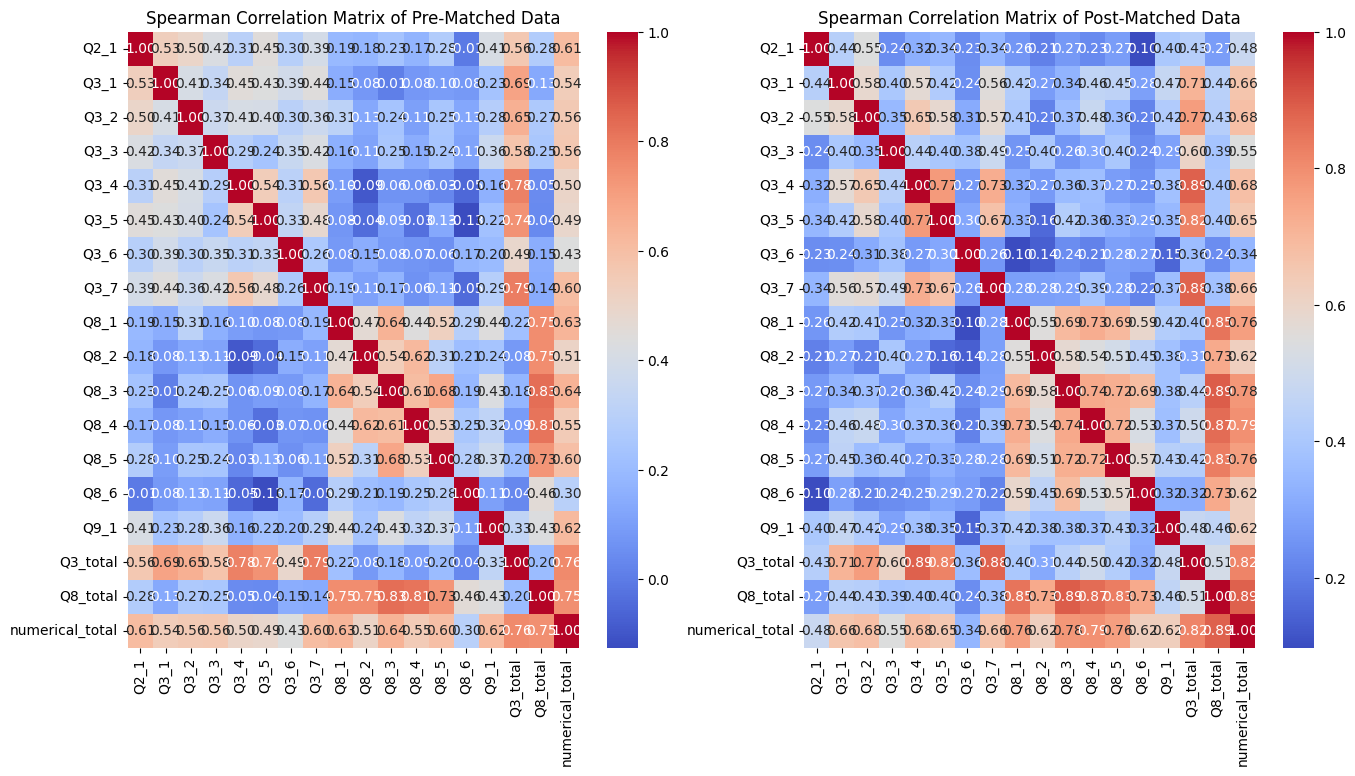

In [ ]:
# Spearman rank-order correlation for pre-matched data
spearman_corr_pre_matched = pre_matched.corr(method='spearman')

# Spearman rank-order correlation for post-matched data
spearman_corr_post_matched = post_matched.corr(method='spearman')

# Plot the heatmap as before, but for Spearman correlations
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
sns.heatmap(spearman_corr_pre_matched, cmap='coolwarm', annot=True, fmt=".2f", ax=axes[0])
axes[0].set_title('Spearman Correlation Matrix of Pre-Matched Data')

sns.heatmap(spearman_corr_post_matched, cmap='coolwarm', annot=True, fmt=".2f", ax=axes[1])
axes[1].set_title('Spearman Correlation Matrix of Post-Matched Data')

plt.show()

In [ ]:
# print the correlation matrices for david in case if he wants them
print(spearman_corr_pre_matched)
print(spearman_corr_post_matched)

                     Q2_1      Q3_1      Q3_2      Q3_3      Q3_4      Q3_5  \
Q2_1             1.000000  0.530863  0.496614  0.420522  0.305045  0.447344   
Q3_1             0.530863  1.000000  0.407230  0.338757  0.454196  0.433796   
Q3_2             0.496614  0.407230  1.000000  0.366195  0.407093  0.402783   
Q3_3             0.420522  0.338757  0.366195  1.000000  0.291426  0.235109   
Q3_4             0.305045  0.454196  0.407093  0.291426  1.000000  0.539884   
Q3_5             0.447344  0.433796  0.402783  0.235109  0.539884  1.000000   
Q3_6             0.295545  0.387848  0.303060  0.350728  0.308130  0.328722   
Q3_7             0.394042  0.441808  0.362709  0.423710  0.561794  0.478145   
Q8_1             0.194156  0.150869  0.312876  0.158031  0.095127  0.076139   
Q8_2             0.179988  0.078175  0.131598  0.113926 -0.092886 -0.041476   
Q8_3             0.231747  0.009209  0.236919  0.246585  0.064565  0.094078   
Q8_4             0.171754  0.078535  0.105189  0.146

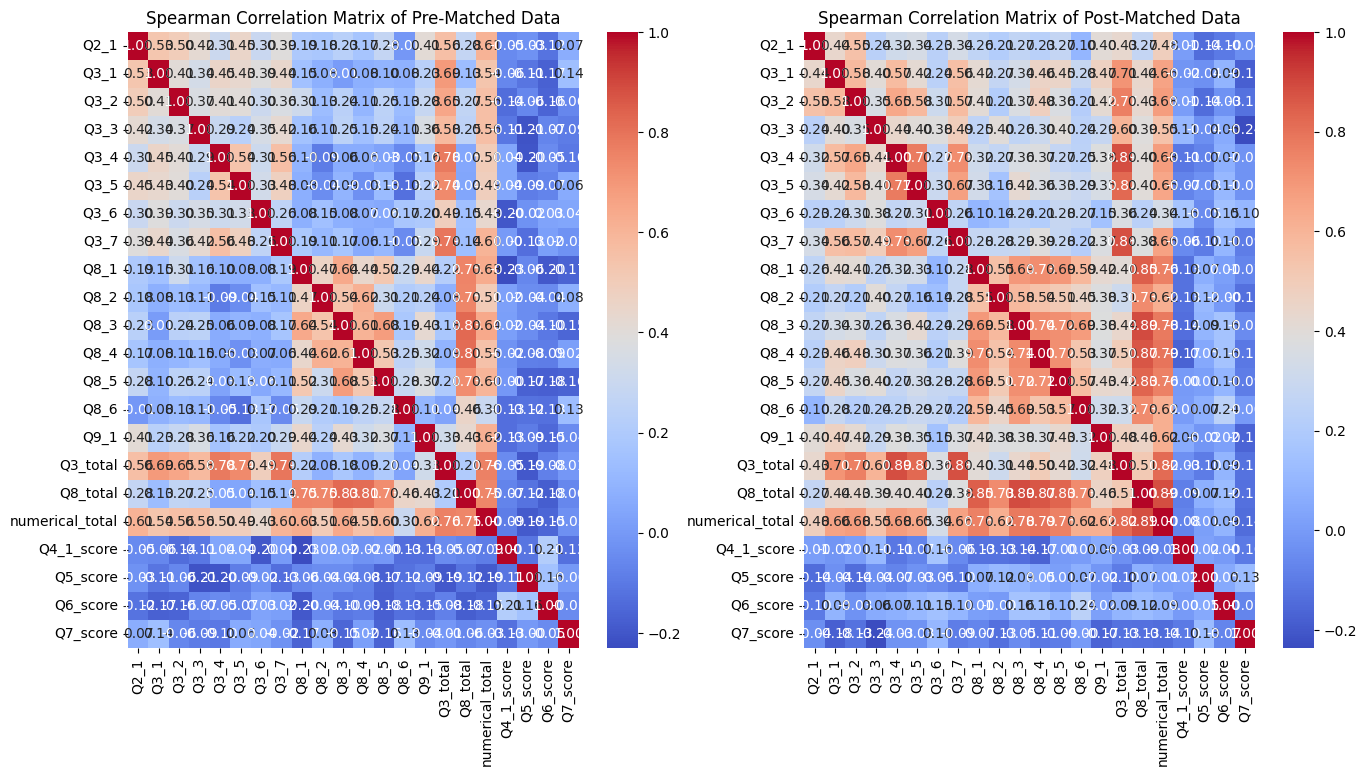

In [ ]:
# Understand how knowledge scores (Q4-7) correlate with opinions Q2, Q3, Q8, Q9

# use pre_matched, post_matched, pre_matched_categorical, post_matched_categorical and put them all together into one big dataframe. The pre_matched and post_matched dataframes will have the same column names and the pre_matched_categorical and post_matched_categorical dataframes will have the same column names. We will then merge the dataframes on the index (NetID) and then calculate the correlations.

# make new dataframes for categorical data to have numeric representations as done earlier
# Define the correct answers for scoring categorical data
correct_answers = {
    'Q4_1': ["2.5", "3", "3.5"],
    'Q5': 'PM < 2.5 μm',
    'Q6': "Particles of this size are generally absorbed in the respiratory tract and safely excreted in mucus.",
    'Q7': ["Cars", "Fireplaces", "Trucks"]
}

def calculate_q7_score(response, correct_answers):
    if isinstance(response, str):  # Check if the response is a string
        user_answers = set(response.split(","))
        correct_set = set(correct_answers)
        correct_count = len(user_answers & correct_set)
        incorrect_count = len(user_answers - correct_set)
        total_score = correct_count / (correct_count + incorrect_count) if (correct_count + incorrect_count) > 0 else 0
        return round(total_score * len(correct_answers), 2)  # Normalize to full score based on correct answers
    else:
        return None  # Return None for non-string responses

# Define a function to score the categorical responses
def score_categorical_data(df):
    df['Q4_1_score'] = df['Q4_1'].apply(lambda x: 1 if x in correct_answers['Q4_1'] else 0)
    df['Q5_score'] = df['Q5'].apply(lambda x: 1 if x == correct_answers['Q5'] else 0)
    df['Q6_score'] = df['Q6'].apply(lambda x: 1 if x == correct_answers['Q6'] else 0)
    df['Q7_score'] = df['Q7'].apply(lambda x: calculate_q7_score(x, correct_answers['Q7']))
    return df[['Q4_1_score', 'Q5_score', 'Q6_score', 'Q7_score']]

scored_data_pre = score_categorical_data(pre_matched_categorical)
scored_data_post = score_categorical_data(post_matched_categorical)

# Merge the dataframes on the index (NetID)
merged_pre = pd.concat([pre_matched, scored_data_pre], axis=1)
merged_post = pd.concat([post_matched, scored_data_post], axis=1)

# Calculate the correlation matrix for the merged data
correlation_matrix_pre = merged_pre.corr(method='spearman')
correlation_matrix_post = merged_post.corr(method='spearman')

# Plot the correlation matrices
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
sns.heatmap(correlation_matrix_pre, cmap='coolwarm', annot=True, fmt=".2f", ax=axes[0])
axes[0].set_title('Spearman Correlation Matrix of Pre-Matched Data')

sns.heatmap(correlation_matrix_post, cmap='coolwarm', annot=True, fmt=".2f", ax=axes[1])
axes[1].set_title('Spearman Correlation Matrix of Post-Matched Data')

plt.show()

In [ ]:
# clean data differently for two way ANOVA
import pandas as pd

# Combine data into a single DataFrame
def add_labels(df, time_label, year_label):
    df = df.copy()  # Make a copy to avoid changing the original dataframe
    df['Time'] = time_label
    df['Year'] = year_label
    return df

# Apply the label addition to each DataFrame
pre_matched_combined = add_labels(pre_matched, 'Pre', '2023')
post_matched_combined = add_labels(post_matched, 'Post', '2023')
pre1_combined = add_labels(pre1, 'Pre', '2024')
pre2_combined = add_labels(pre2, 'Pre', '2024')
post_unmatched_combined = add_labels(post_unmatched, 'Post', '2024')

# Concatenate all DataFrames into one
combined_df = pd.concat([pre_matched_combined, post_matched_combined, pre1_combined, pre2_combined, post_unmatched_combined])

# Drop rows with NaN values in key columns
combined_df = combined_df.dropna()

questions = ['Q2_1', 'Q3_1', 'Q3_2', 'Q3_3', 'Q3_4', 'Q3_5', 'Q3_6', 'Q3_7', 'Q8_1', 'Q8_2', 'Q8_3', 'Q8_4']

for question in questions:
    model = ols(f'{question} ~ Time * Year', data=combined_df).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    print(f'ANOVA results for {question}:')
    print(anova_table)
    print()

ANOVA results for Q2_1:
               sum_sq     df          F        PR(>F)
Time        25.069766    1.0  44.516498  7.427414e-11
Year         0.242772    1.0   0.431090  5.117900e-01
Time:Year    0.084650    1.0   0.150314  6.984187e-01
Residual   253.420532  450.0        NaN           NaN

ANOVA results for Q3_1:
               sum_sq     df          F    PR(>F)
Time        19.106444    1.0  20.950619  0.000006
Year         0.011581    1.0   0.012699  0.910325
Time:Year    0.406470    1.0   0.445703  0.504725
Residual   410.388822  450.0        NaN       NaN

ANOVA results for Q3_2:
               sum_sq     df         F    PR(>F)
Time         0.528270    1.0  0.518314  0.471936
Year         3.986596    1.0  3.911462  0.048568
Time:Year    0.109375    1.0  0.107314  0.743375
Residual   458.643917  450.0       NaN       NaN

ANOVA results for Q3_3:
               sum_sq     df         F    PR(>F)
Time         2.716045    1.0  4.210613  0.040750
Year         0.079667    1.0  0.123506

In [ ]:
# This code is not used. I kept it in case we do decide/ figure out how to create a composite score for the 4 knowledge questions.

# # Perform Analysis of pre and post composite scores stored in variable pre_composite_score and post_composite_score

# # These are from pre and post unmatched data
# # Perform the unpaired t-test
# stat, p_value = ttest_ind(pre_composite_score, post_composite_score, equal_var=True)  # Set equal_var to True if variances are assumed equal

# # Calculate the 95% confidence interval
# mean_diff = np.mean(pre_composite_score) - np.mean(post_composite_score)
# sem_pre = sem(pre_composite_score)
# sem_post = sem(post_composite_score)
# ci_low, ci_upp = t.interval(0.95, df=len(pre_composite_score)+len(post_composite_score)-2, loc=mean_diff, scale=np.sqrt(sem_pre**2 + sem_post**2))

# print(f"Unpaired t-test for composite scores (pre vs. post unmatched):")
# print(f"Statistic: {stat:.3f}")
# print(f"P-value: {p_value:.3f}")
# print(f"95% Confidence interval for the difference in means: ({ci_low:.3f}, {ci_upp:.3f})")
# print(f"Length of pre_composite_score: {len(pre_composite_score)}")
# print(f"Length of post_composite_score: {len(post_composite_score)}")



# Create correlations between the composite scores for knowledge and the opinion questions
# get IDs from pre_categorical_unmatched and post_categorical_unmatched
# pre_ids = pre_categorical_unmatched.index
# post_ids = post_categorical_unmatched.index